In [488]:
import sys

sys.path.append("..")

In [489]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, m_e, eV, epsilon_0, e, physical_constants
from scipy.sparse.linalg import eigsh, cg
from scipy.linalg import eigh, eig
from scipy.sparse import csr_matrix
from scipy.integrate import simpson
import src.matrix_element_1d_sparse
import importlib
from src.matrix_element_1d_sparse import *

importlib.reload(src.matrix_element_1d_sparse)

<module 'src.matrix_element_1d_sparse' from '/home/yamamoto/physics/fem/fem_schrodinger/examples/../src/matrix_element_1d_sparse.py'>

In [517]:
xs = np.linspace(1e-20, 1e-9, 1000)

x_centers = (xs[1:] + xs[:-1]) / 2
v = -1 / x_centers
femeig = Mel1dSparse(xs)
K0 = femeig.get_K()
M = femeig.get_M()
K1 = femeig.get_M(v)

# まずcoo_matrixからcsr_matrixへ変換
K0_csr = csr_matrix(K0)
M_csr = csr_matrix(M)
K1_csr = csr_matrix(K1)

# csr_matrixを使用してスライスする
K0_dirichlet = K0_csr[1:-1, 1:-1]
M_dirichlet = M_csr[1:-1, 1:-1]
K1_dirichlet = K1_csr[1:-1, 1:-1]
k = 3
C0 = hbar**2 / (m_e)
C1 = e**2 / (4 * np.pi * epsilon_0)
val, vec = eigsh(
    -1 / 2 * C0 * K0_dirichlet + C1 * K1_dirichlet,
    k=k,
    M=M_dirichlet,
    which="LA",
    sigma=-20 * eV,
)

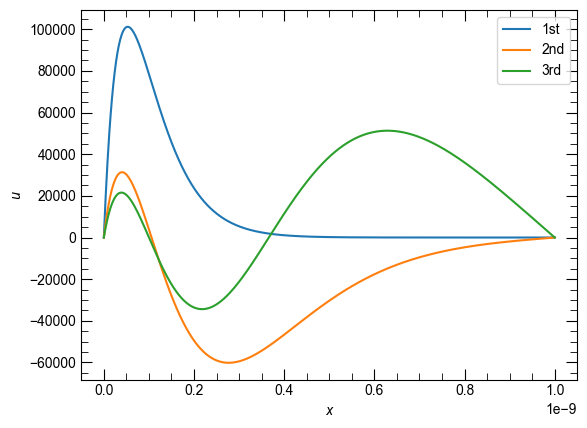

In [518]:
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [623]:
F = femeig.get_F(e * vec_0[:, 0] ** 2 / (4 * np.pi * x_centers**2) / epsilon_0)
F = x_centers**2 * F[:-1]
K_poisson = femeig.get_K(x_centers**2)
K_poisson_csr = csr_matrix(K_poisson)
K_poisson_dirichlet = K_poisson_csr[:-1, :-1]
F[-1] -= K_poisson_csr[-2, -1] * (-e / (4 * np.pi * epsilon_0 * x_centers[-1]))

In [624]:
x, info = cg(K_poisson_dirichlet, F)

(-10.0, 0.0)

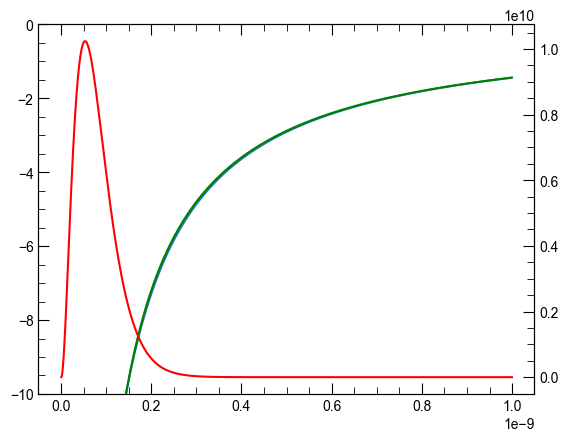

In [625]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(xs[:-1], x)
ax2.plot(x_centers, vec_0[:, 0] ** 2, color="red")
ax.plot(xs[:-1], -e / (4 * np.pi * epsilon_0 * xs[:-1]), color="green")
ax.set_ylim(-1e1, 0)

In [504]:
e

1.602176634e-19

In [505]:
epsilon_0

8.8541878128e-12

In [506]:
e / (4 * np.pi * epsilon_0 * 1e-9)

1.4399645478425669

(-10.0, 0.0)

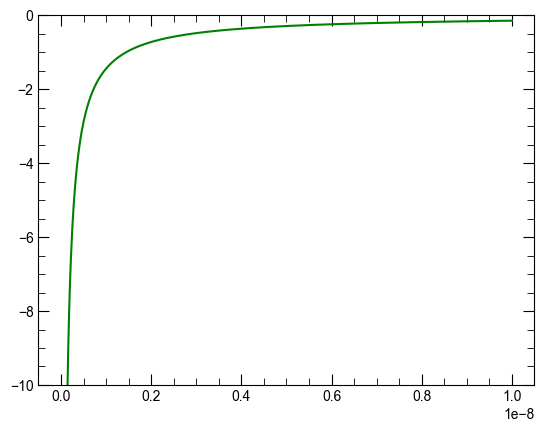

In [507]:
x_large = np.linspace(1e-20, 1e-8, 1000)
fig, ax = plt.subplots()
ax.plot(x_large, -e / (4 * np.pi * epsilon_0 * x_large), color="green")
ax.set_ylim(-1e1, 0)

In [508]:
vals = []
part1 = np.arange(10, 100, 10)
part2 = np.arange(100, 1000, 100)
part3 = np.arange(1000, 10000, 1000)
combined = np.concatenate((part1, part2, part3))
for i in combined:
    print(i)
    xs = np.linspace(1e-15, 1e-9, i)
    x_centers = (xs[1:] + xs[:-1]) / 2
    vs = -1 / x_centers
    femeig = Mel1dSparse(xs)
    K0 = femeig.get_K()
    M = femeig.get_M()
    K1 = femeig.get_M(vs)

    # まずcoo_matrixからcsr_matrixへ変換
    K0_csr = csr_matrix(K0)
    M_csr = csr_matrix(M)
    K1_csr = csr_matrix(K1)

    # csr_matrixを使用してスライスする
    K0_dirichlet = K0_csr[1:-1, 1:-1]
    M_dirichlet = M_csr[1:-1, 1:-1]
    K1_dirichlet = K1_csr[1:-1, 1:-1]
    val, vec = eigsh(
        -1 / 2 * C0 * K0_dirichlet + C1 * K1_dirichlet,
        k=1,
        M=M_dirichlet,
        which="LM",
        sigma=-20 * eV,
    )
    vals.append(val)

10
20
30
40
50
60
70
80
90
100
200
300
400
500
600
700
800
900
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [509]:
Ry = physical_constants["Rydberg constant times hc in eV"][0]
err = np.abs(-Ry - np.array(vals) / eV) / (Ry)
err

array([[2.85615195e-01],
       [6.45381880e-02],
       [1.85794242e-03],
       [2.26746461e-02],
       [2.83227914e-02],
       [2.86007072e-02],
       [2.69926440e-02],
       [2.48181696e-02],
       [2.25896859e-02],
       [2.05001142e-02],
       [8.87063168e-03],
       [4.91826900e-03],
       [3.14382675e-03],
       [2.18977801e-03],
       [1.61433793e-03],
       [1.23872726e-03],
       [9.79030122e-04],
       [7.91440621e-04],
       [6.51191245e-04],
       [1.46498555e-04],
       [3.36296844e-05],
       [9.96323824e-06],
       [3.15120307e-05],
       [4.38037301e-05],
       [5.15068851e-05],
       [5.66677015e-05],
       [6.03020397e-05]])

[1.]


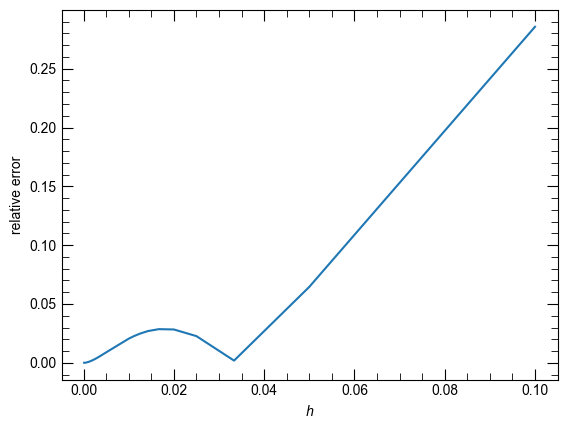

In [510]:
fig, ax = plt.subplots()
ax.plot(1 / combined, err)
ax.set_xlabel("$h$")
ax.set_ylabel("relative error")
print((np.pi**2 - vals[-1]) / (np.pi**2))
fig.savefig("convergence.pdf")

[1.]


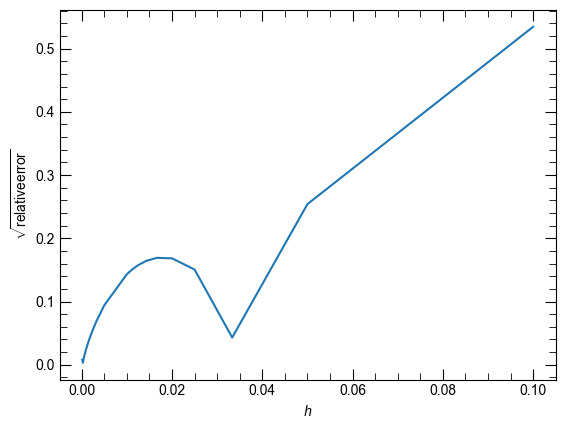

In [511]:
fig, ax = plt.subplots()
ax.plot(1 / combined, np.sqrt(err))
ax.set_xlabel("$h$")
ax.set_ylabel(r"$\sqrt{\mathrm{relative error}}$")
print((np.pi**2 - vals[-1]) / (np.pi**2))
fig.savefig("figs/convergence_sqrt.pdf")

In [512]:
1 / combined, np.abs(-Ry - np.array(vals) / eV) / (Ry)

(array([0.1       , 0.05      , 0.03333333, 0.025     , 0.02      ,
        0.01666667, 0.01428571, 0.0125    , 0.01111111, 0.01      ,
        0.005     , 0.00333333, 0.0025    , 0.002     , 0.00166667,
        0.00142857, 0.00125   , 0.00111111, 0.001     , 0.0005    ,
        0.00033333, 0.00025   , 0.0002    , 0.00016667, 0.00014286,
        0.000125  , 0.00011111]),
 array([[2.85615195e-01],
        [6.45381880e-02],
        [1.85794242e-03],
        [2.26746461e-02],
        [2.83227914e-02],
        [2.86007072e-02],
        [2.69926440e-02],
        [2.48181696e-02],
        [2.25896859e-02],
        [2.05001142e-02],
        [8.87063168e-03],
        [4.91826900e-03],
        [3.14382675e-03],
        [2.18977801e-03],
        [1.61433793e-03],
        [1.23872726e-03],
        [9.79030122e-04],
        [7.91440621e-04],
        [6.51191245e-04],
        [1.46498555e-04],
        [3.36296844e-05],
        [9.96323824e-06],
        [3.15120307e-05],
        [4.38037301e-05],
  